In [ ]:
import pandas as pd
import scanpy as sc
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import random
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
sc.settings.set_figure_params(
    dpi=80,
    frameon=False,  
)
plt.rcParams['axes.grid'] = False

In [3]:
annotations = sc.read_h5ad('integrated.h5ad') # fully processed adata up to cell type annotation

c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
annotations

AnnData object with n_obs × n_vars = 33564 × 19958
    obs: 'revised_prediction', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', 'leiden_0_25', '_scvi_raw_norm_scaling', 'cell type', 'cell_type'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell type_colors', 'cell_type_colors', 'de_genes', 'de_genes_scvi', 'dea_by_sample', 'dendrogram_leiden_0_25', 'dendrogram_sample', 'leiden', 'leiden_0_25', 'leiden_0_25_colors', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    varm: 'PCs'
    layers: 'raw_counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [102]:
adata = sc.read_h5ad('combined_adata.h5ad') # combined data from donor1 2 and 3. Not normalized.
adata.obsm['X_umap'] = annotations.obsm['X_umap'] #add umap coords
adata.obs['cell_type'] = annotations.obs['cell_type'] #add cell labels

adata

c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 33564 × 19958
    obs: 'revised_prediction', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'cell_type'
    obsm: 'X_umap'

In [ ]:
# since this is concatanated dataset 'adata = sc.concat([adata1, adata2, adata3])'
# the cell barcodes from each dataset weren’t made unique
# to solve this automatically append suffixes like -1, -2, etc. to any duplicate barcodes

adata.obs_names_make_unique()

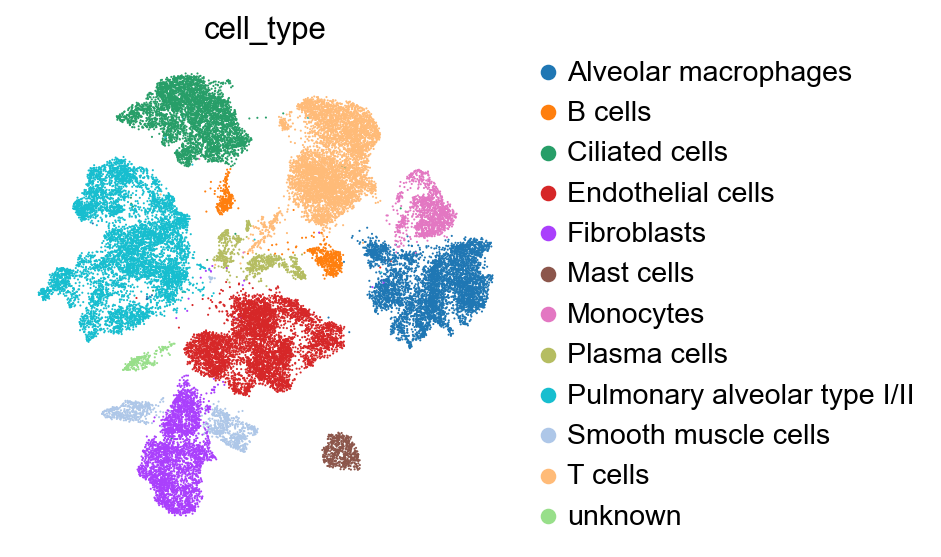

In [107]:
sc.pl.umap(adata, color='cell_type')

In [108]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

#### Feature importance example

In [ ]:
def label(x):
    if x == 'Fibroblasts':
        return 1
    else:
        return 0

In [ ]:
y = adata.obs.cell_type.map(label) # y = 1 if cell_type is Fibroblasts, 0 otherwise.

In [11]:
sel = RandomForestClassifier(n_jobs = 10, n_estimators=100)
sel.fit(adata.X, y)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [12]:
# adata.X (expression matrix) and adata.var_names has the same order so
pd.DataFrame(sel.feature_importances_,
                  index = adata.var_names).sort_values(0, ascending = False)

,0
FBLN1,0.021714
LUM,0.019427
NBL1,0.019023
A2M,0.018775
C1S,0.017735
...,...
TAS1R3,0.000000
CPTP,0.000000
SCNN1D,0.000000
AL162741.1,0.000000


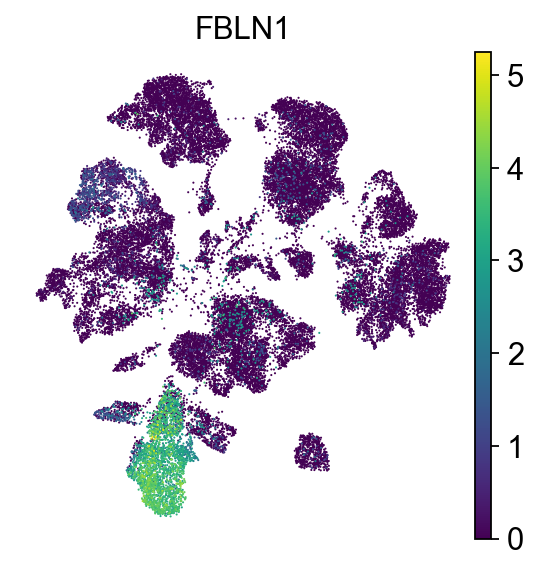

In [13]:
sc.pl.umap(adata, color = 'FBLN1')

#### Binary classification example

In [20]:
def label2(x):
    if x == 'Ciliated cells':
        return 1
    else:
        return 0

In [21]:
target = adata.obs.cell_type.map(label2) # target = 1 if cell_type is Ciliated cells, 0 otherwise.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [24]:
X_train, X_test, y_train, y_test = train_test_split(adata.X, target, test_size=0.2, random_state=42, stratify=y)

In [48]:
X_train

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 50426182 stored elements and shape (26851, 19958)>

In [ ]:
y_train.value_counts() # large disparity in number between 2 classes

cell_type
0    23622
1     3229
Name: count, dtype: int64

In [49]:
X_test

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 12635627 stored elements and shape (6713, 19958)>

In [25]:
sel = RandomForestClassifier(n_jobs=10, n_estimators=100, random_state=42)
sel.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [26]:
y_pred = sel.predict(X_test)

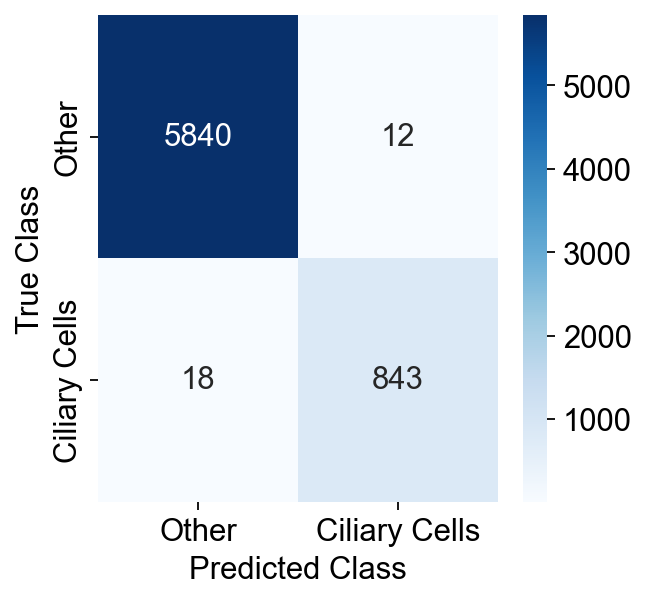

In [46]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=True, 
            xticklabels=["Other","Ciliary Cells"], 
            yticklabels=["Other","Ciliary Cells"])

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In [52]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9955


##### Classification example 

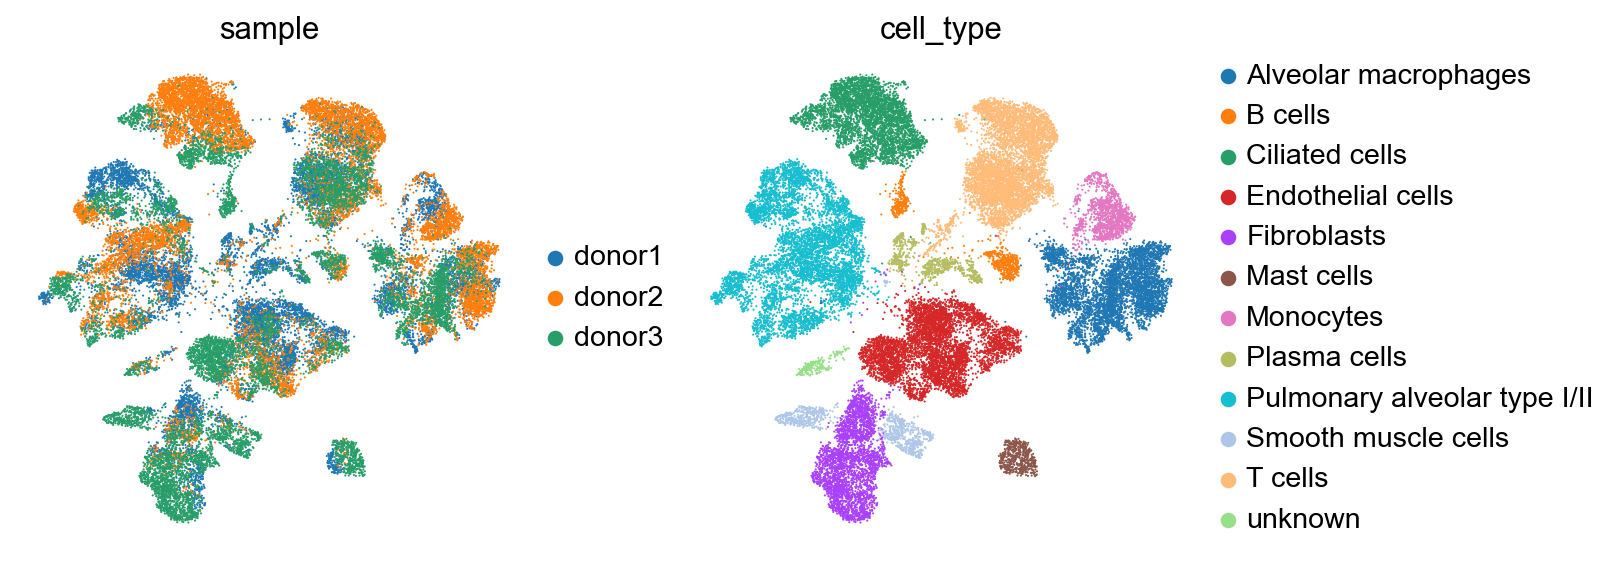

In [142]:
sc.pl.umap(adata, color=['sample', 'cell_type'])

In [143]:
endo = adata[adata.obs.cell_type == "Endothelial cells"]
endo

View of AnnData object with n_obs × n_vars = 5470 × 19958
    obs: 'revised_prediction', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'cell_type'
    uns: 'cell_type_colors', 'log1p', 'sample_colors'
    obsm: 'X_umap'

In [144]:
sc.pp.filter_genes(endo, min_cells=100)
endo

c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\scanpy\preprocessing\_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


AnnData object with n_obs × n_vars = 5470 × 10485
    obs: 'revised_prediction', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'cell_type'
    var: 'n_cells'
    uns: 'cell_type_colors', 'log1p', 'sample_colors'
    obsm: 'X_umap'

In [145]:
sc.pp.highly_variable_genes(endo, subset=True, n_top_genes = 2000)

In [147]:
X = endo.X

In [148]:
y = endo.obs['sample'].values

In [149]:
y

['donor1', 'donor1', 'donor1', 'donor1', 'donor1', ..., 'donor3', 'donor3', 'donor3', 'donor3', 'donor3']
Length: 5470
Categories (3, object): ['donor1', 'donor2', 'donor3']

In [150]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 20% test
    random_state=42,     # reproducible
    stratify=y           # ensures same proportion of donors in train/test
)


In [151]:
rf = RandomForestClassifier(
    n_estimators=100,     # number of trees
    random_state=42,
    n_jobs=10            # use all CPU cores
)

In [152]:
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [153]:
y_pred = rf.predict(X_test)

In [ ]:
acc = accuracy_score(y_test, y_pred) # or metrics.accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.3f}")

Test accuracy: 0.974


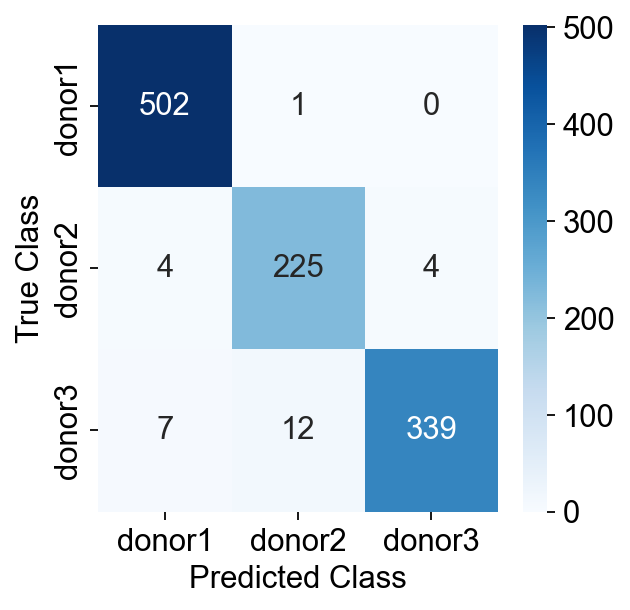

In [156]:
cm = confusion_matrix(y_test, y_pred)

donor_labels = np.unique(y)  # e.g., array(['donor1','donor2','donor3'])

sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=True,
            xticklabels=donor_labels,
            yticklabels=donor_labels)

plt.xlabel("Predicted Class")
plt.ylabel("True Class")

plt.show()